In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import os

from scipy import interpolate
dpi=100

In [3]:
filename = "Hansen_88_plot_data.xls"
filedata = pd.read_excel(filename)

In [4]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0., 0.9)
new_cmap.set_bad(color = 'w', alpha = 1.)


Reading cowtan_way_forcings.csv
Reading gistemp_forcings.csv
Reading hadcrut4_forcings.csv
Reading noaa_forcings.csv
Reading berkeley_forcings.csv


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


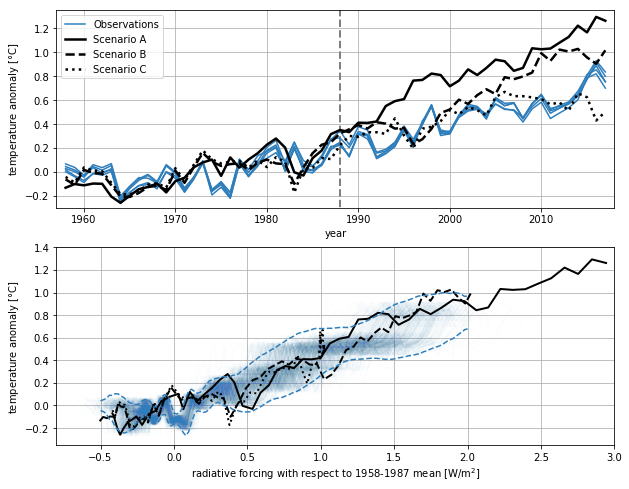

In [5]:
plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot([1988,1988],[-1.,2.],'--',lw=2,color='grey')
T_keys = ['gistemp', 'hadcrut4', 'ncdc', 'berkeley', 'cowtanandway', 'hansen_1988_a_t', 'hansen_1988_b_t', 'hansen_1988_c_t']
first = 0
hansen_linestyle_idx = 0
hansen_linestyle = ['-','--',':']
hansen_labels = ['Scenario A', 'Scenario B', 'Scenario C']
for T_key in T_keys:
    if 'hansen' in T_key:
        plt.plot(filedata['year'],filedata[T_key], label=hansen_labels[hansen_linestyle_idx],
                 linestyle=hansen_linestyle[hansen_linestyle_idx],color='k',lw=2.5)
        hansen_linestyle_idx += 1
    else:
        if 'gistemp' in T_key: label = 'Observations'
        else: label = ''
        plt.plot(filedata['year'],filedata[T_key],label=label,color=cmap(0.7),lw=1.5)
plt.xlim([1957,2018])
plt.ylim([-0.3,1.35])
plt.grid(True)
plt.xlabel(r"year")
plt.ylabel(r"temperature anomaly [$\degree$C]")
plt.legend()

plt.subplot(2,1,2)



df=0.02
env_f = np.arange(-1.0,2.5,df)
env_t = np.zeros((env_f.size,1000))

forcing_itp = np.arange(-1.0,2.5,df/10)

for filename in os.listdir("./"):
    if not ".csv" in filename: continue
    print("Reading "+filename,end="\n")
    
    obsdata = pd.read_csv(filename)
    years = np.array(obsdata["year"])
    temp = np.array(obsdata["temp"])
    
    plot_indices = np.random.randint(0, high=1000, size=100)
    for forcing_num in range(1000):
        forcing = np.array(obsdata["forcing_"+str(forcing_num)])
        
        itp = interpolate.interp1d(forcing, temp, fill_value = np.nan, bounds_error=False)
        temp_itp = itp(forcing_itp)
        
        # find envelope
        for f_idx in range(0,env_f.size):
            gt_mask = (forcing_itp >= env_f[f_idx] - df/2.)
            lt_mask = (forcing_itp <= env_f[f_idx] + df/2.)
            mask = gt_mask & lt_mask
            if np.any(mask):
                env_t[f_idx,forcing_num] = np.mean(temp_itp[mask])
            else:
                env_t[f_idx,forcing_num] = np.nan
   
        if forcing_num in plot_indices:
            plt.plot(forcing,temp,color=cmap(0.7),alpha=0.015,lw=1.0)
        
env_t_mean = np.nanmean(env_t,axis=1)
env_t_std = np.nanstd(env_t,axis=1)
env_t_upper = env_t_mean+1.96*env_t_std
env_t_lower = env_t_mean-1.96*env_t_std

small_sample_mask = ((~np.isnan(env_t)).sum(axis=1) < 50)
env_t_upper[small_sample_mask] = np.nan
env_t_lower[small_sample_mask] = np.nan

hansen_labels = ['a','b','c']
hansen_linestyle = ['-','--',':']
hansen_linestyle_idx = 0
for hansen_label in hansen_labels:
    plt.plot(filedata['hansen_1988_{0}_f'.format(hansen_label)],
             filedata['hansen_1988_{0}_t'.format(hansen_label)],
             linestyle=hansen_linestyle[hansen_linestyle_idx],color='k',lw=2)
    hansen_linestyle_idx += 1

plt.plot(env_f,env_t_upper,color=cmap(0.7),lw=1.5, linestyle='--')
plt.plot(env_f,env_t_lower,color=cmap(0.7),lw=1.5, linestyle='--')
plt.xlabel(r"radiative forcing with respect to 1958-1987 mean [W/m$^{2}$]")
plt.ylabel(r"temperature anomaly [$\degree$C]")
plt.ylim([-0.35,1.4])
plt.xlim([-0.8,3.0])
plt.grid(True)

plt.savefig("temperature_forcing_spaghetti.png",dpi=300,bbox_inches="tight")